# Training autoencoders and denoising autoencoders
### Application to the MNIST dataset

YJ Choe (yojoongc@andrew.cmu.edu)

#### Setup

In [1]:
%cd ../code/NN/

/Users/YJ/Dropbox/Code/deep_learning/hw2/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from autoencoder import Autoencoder
from nn.nn import NN
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Load and binarize data

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

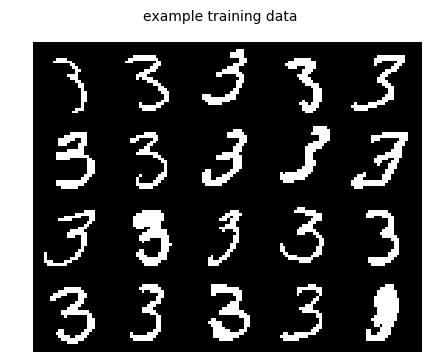

In [6]:
print_image(X_train[1160:1180, :], output_shape=(4, 5), 
            title='example training data')
None # should be binarized

## (e) Autoencoders

### Model initialization

Tied weights $W \in \mathbb{R}^{n_{hidden} \times n_{visible}}$ are initialized from a $\mathrm{Unif}(-u, u)$ where $u = \frac{\sqrt{6}}{\sqrt{n_{visible}+n_{hidden}}}$, as described in the lecture. Bias terms are initialized to zero.

Learning rate is initialized at 0.1, and is halved after every 100 epochs.

In [7]:
ae = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                 activation='sigmoid', denoising=0.0,
                 learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                 early_stopping=True, seed=0)

In [8]:
ae.W.shape, ae.b.shape, ae.c.shape

((100, 784), (100, 1), (784, 1))

In [9]:
[l.__name__ for l in ae.layers]

['AE_input_layer', 'AE_output_layer']

### Training

Note that we train less number of epochs for autoencoders compared to RBMs, as they seem to show good reconstruction performance (which is their primary goal) earlier than RBMs do. 

In [10]:
n_epoch = 200
ae.train(X_train, X_valid,
         batch_size=200, n_epoch=n_epoch, batch_seed=25, 
         verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         254.23563         |         255.99015         |
|    2  |         148.13829         |         149.46294         |
|    3  |         133.92771         |         135.74770         |
|    4  |         124.81054         |         126.99349         |
|    5  |         117.97219         |         120.34700         |
|    6  |         112.68816         |         115.28634         |
|    7  |         108.15671         |         110.97000         |
|    8  |         104.57765         |         107.59971         |
|    9  |         101.30716         |         104.57972         |
|   10  |          98.40196         |         101.91343         |
|   11  | 

Next, we show the plots of training and validation errors. The validation error starts to plateau after 100 epoches.

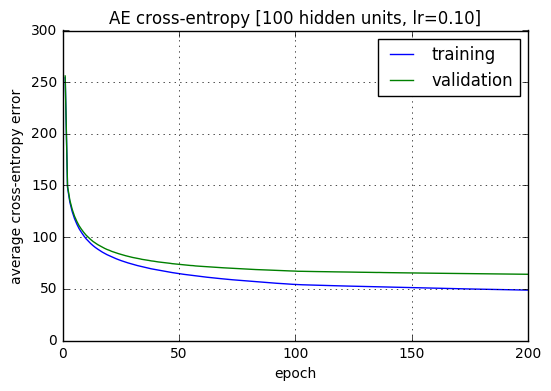

In [11]:
plt.grid()
plt.plot(*zip(*ae.training_error), label='training')
plt.plot(*zip(*ae.validation_error), label='validation')
plt.title('AE cross-entropy [100 hidden units, lr={:.2f}]'.format(ae.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

### Visualizing parameters

First, we take the first hidden layer units and plot them as images. As shown below, the filters seem to capture digit-like shapes, as we saw with 2-layer feedforward neural networks. 

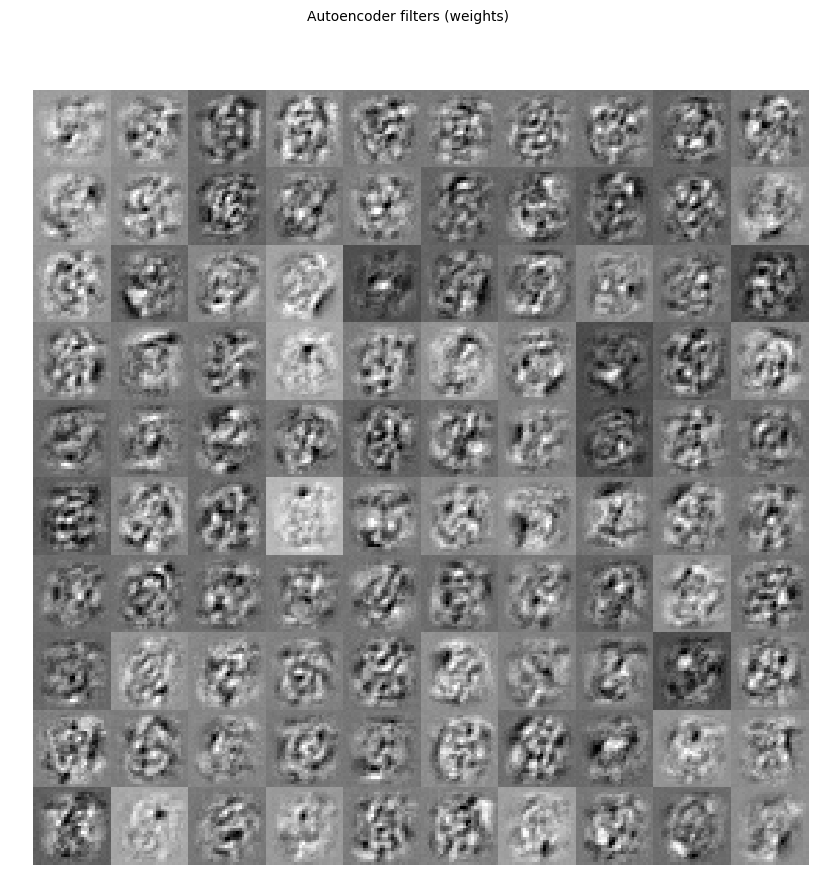

In [12]:
assert ae.W.shape[0] >= 100
print_image(ae.W[:100,:], output_shape=(10, 10),
            title='Autoencoder filters (weights)')
None

The filters are slightly blurrier than those from RBM, as expected. Denoising autoencoders might help (later) if we want sharper filters.

Next, we generate 25 reconstructions on unseen data using the trained AE. The quality of reconstruction is surprisingly good.

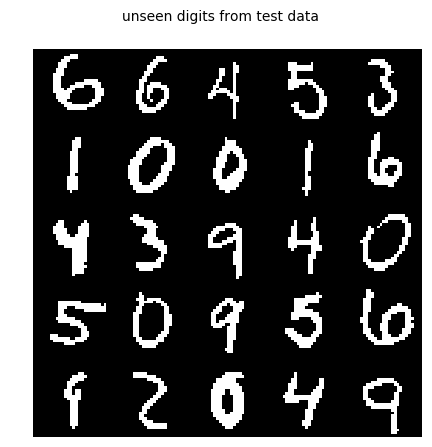

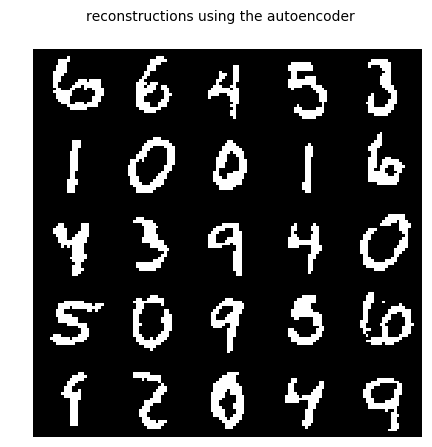

In [13]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = ae.reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='unseen digits from test data')
print_image(X_rec, output_shape=(5, 5),
            title='reconstructions using the autoencoder')
None

### Autoencoders for pre-training

Here we train a 1-layer neural network with weights learned from AE and compare with randomly initialized weights.

In [14]:
# Random initialization
nn_random = NN(architecture=[784, 100, 10], 
               activation='sigmoid', learning_rate=0.01, momentum=0.7,
               weight_decay=1e-4, dropout=0.0, early_stopping=True, 
               seed=40)
nn_random.train(X_train, y_train, X_valid, y_valid,
                batch_size=200, n_epoch=n_epoch, batch_seed=25,
                verbose=False)  # silent run
None

In [15]:
# AE-learned initialization
nn_ae = NN(architecture=[784, 100, 10], 
           activation='sigmoid', learning_rate=0.01, momentum=0.7,
           weight_decay=1e-4, dropout=0.0, early_stopping=True, 
           seed=40)
nn_ae.layers[0].W = ae.W
nn_ae.train(X_train, y_train, X_valid, y_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25,
            verbose=False)  # silent run
None

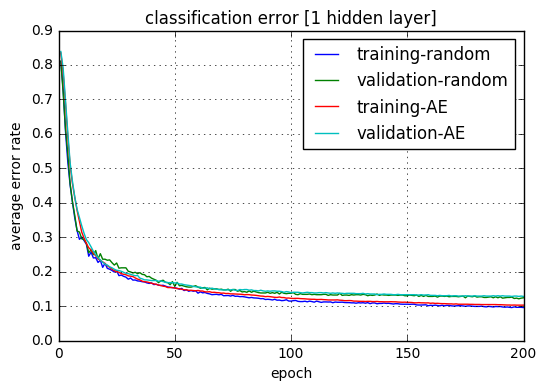

In [16]:
# Error rate
plt.grid()
plt.plot(*zip(*nn_random.training_error), label='training-random')
plt.plot(*zip(*nn_random.validation_error), label='validation-random')
plt.plot(*zip(*nn_ae.training_error), label='training-AE')
plt.plot(*zip(*nn_ae.validation_error), label='validation-AE')
plt.title('classification error [1 hidden layer]')
plt.xlabel('epoch')
plt.ylabel('average error rate')
plt.legend()
plt.show()

Here, it appears that the autoencoder-pretrained weights actually help achieve a lower error rate at the beginning. Eventually, randomly initialized NN follows up with the AE-initialized NN to achieve the same error rate. Note that this result is better than the RBM-pretrained version which actually performed worse for classification.

## (f) Denoising autoencoders

We try two denoising rates of 25% and 50%.

In [17]:
dae25 = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                    activation='sigmoid', denoising=0.25,
                    learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                    early_stopping=True, seed=2)
dae25.train(X_train, X_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25, 
            verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         221.99919         |         223.00259         |
|    2  |         150.57744         |         151.74980         |
|    3  |         136.99928         |         138.62415         |
|    4  |         127.87120         |         129.89104         |
|    5  |         120.99948         |         123.24636         |
|    6  |         115.61570         |         118.14222         |
|    7  |         111.32141         |         114.03616         |
|    8  |         107.63226         |         110.55258         |
|    9  |         104.34197         |         107.48171         |
|   10  |         101.71883         |         105.04269         |
|   11  | 

In [18]:
dae50 = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                    activation='sigmoid', denoising=0.50,
                    learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                    early_stopping=True, seed=2)
dae50.train(X_train, X_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25, 
            verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         194.38222         |         194.73252         |
|    2  |         157.56195         |         158.68905         |
|    3  |         143.98479         |         145.66850         |
|    4  |         134.95629         |         137.01118         |
|    5  |         127.80855         |         130.08848         |
|    6  |         122.25145         |         124.77182         |
|    7  |         118.66312         |         121.35424         |
|    8  |         114.83806         |         117.78267         |
|    9  |         111.86747         |         114.97556         |
|   10  |         109.25972         |         112.61250         |
|   11  | 

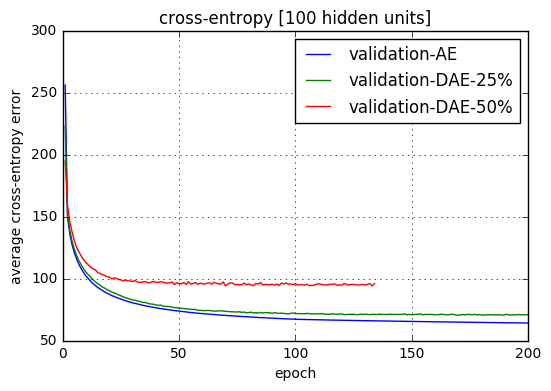

In [19]:
# Error rate
plt.grid()
#plt.plot(*zip(*ae.training_error), label='training-AE')
plt.plot(*zip(*ae.validation_error), label='validation-AE')
#plt.plot(*zip(*dae25.training_error), label='training-DAE-25%')
plt.plot(*zip(*dae25.validation_error), label='validation-DAE-25%')
#plt.plot(*zip(*dae50.training_error), label='training-DAE-50%')
plt.plot(*zip(*dae50.validation_error), label='validation-DAE-50%')
plt.title('cross-entropy [100 hidden units]')
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

The plot above shows that the cross-entropy error on validation set for 25% is smaller than for 50%, but both are greater than not using the non-denoising autoencoder. We also examine the filters.

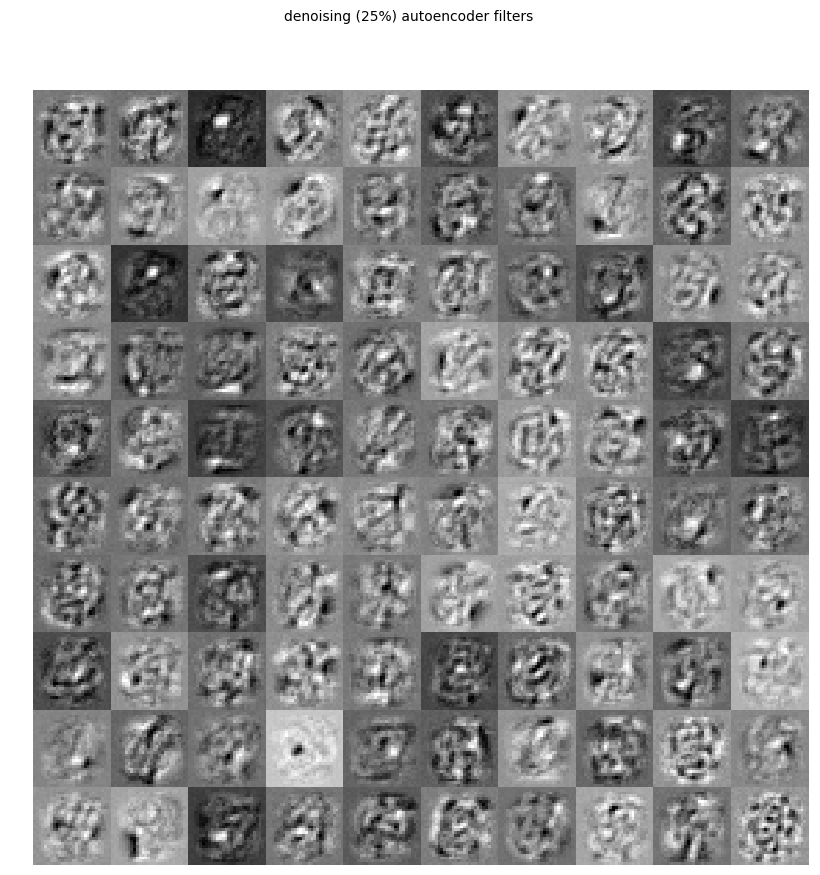

In [20]:
assert dae25.W.shape[0] >= 100
print_image(dae25.W[:100,:], output_shape=(10, 10),
            title='denoising (25%) autoencoder filters')
None

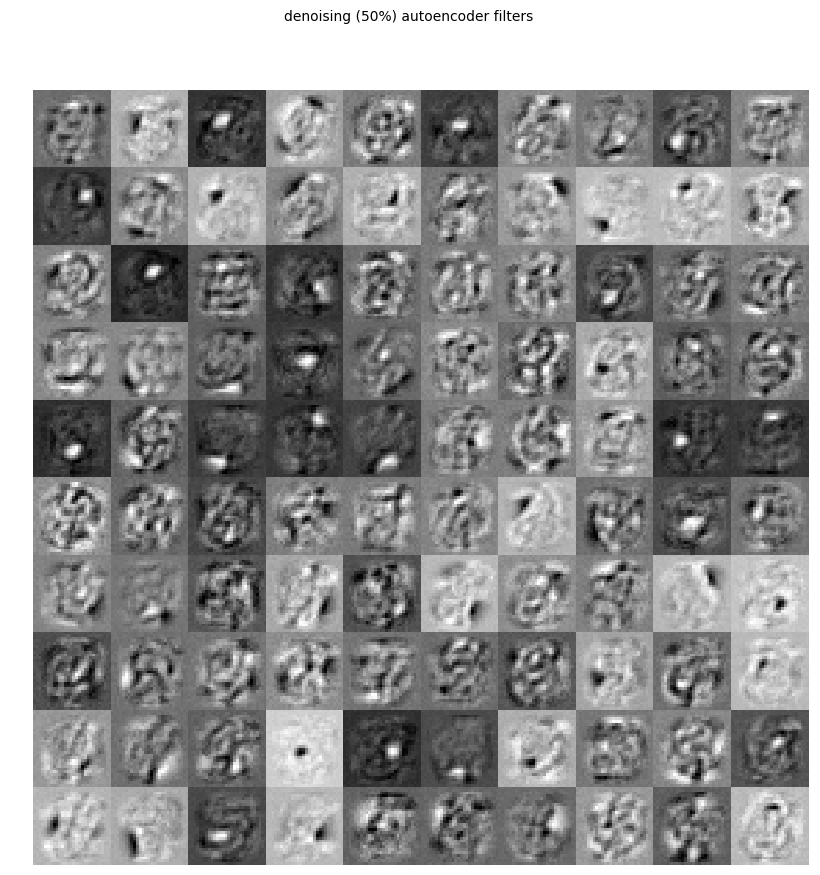

In [21]:
assert dae50.W.shape[0] >= 100
print_image(dae50.W[:100,:], output_shape=(10, 10),
            title='denoising (50%) autoencoder filters')
None

As we saw in class, 50% DAE seems to have sharper filters than 25% DAE, which has a bit sharper filters than the vanilla AE. We proceed with the 25% DAE however, since it seems to achieve a better validation error rate.

Next, we try using the DAE weights as pre-trained features for a feedforward NN classifier.

In [27]:
# DAE-learned initialization
nn_dae = NN(architecture=[784, 100, 10], 
            activation='sigmoid', learning_rate=0.01, momentum=0.7,
            weight_decay=1e-4, dropout=0.0, early_stopping=True, 
            seed=40)
nn_dae.layers[0].W = dae25.W
nn_dae.train(X_train, y_train, X_valid, y_valid,
             batch_size=200, n_epoch=n_epoch, batch_seed=25,
             verbose=False)  # silent run
None

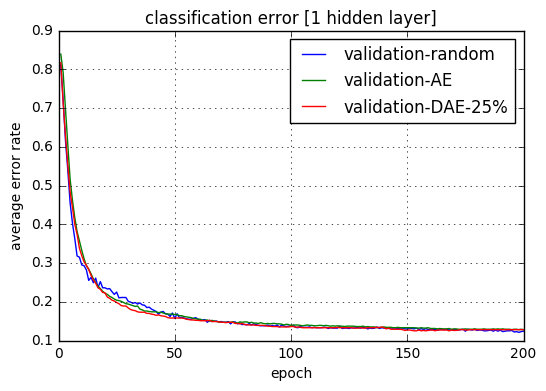

In [28]:
# Error rate
plt.grid()
plt.plot(*zip(*nn_random.validation_error), label='validation-random')
plt.plot(*zip(*nn_ae.validation_error), label='validation-AE')
plt.plot(*zip(*nn_dae.validation_error), label='validation-DAE-25%')
plt.title('classification error [1 hidden layer]')
plt.xlabel('epoch')
plt.ylabel('average error rate')
plt.legend()
plt.show()

Pretraining using a 25%-DAE seems to make a slight improvement in the validation error, even more than AE, early in the training (<50 epochs.) As before, the validation error for seems to stabilize in this particular dataset because we don't really have a larger pool of unlabelled data so that the feedforward NN can eventually catch up.

## (g) Number of hidden units *[for AE and DAE]*

###### See `rbm_mnist.ipynb` for this experiment with autoencoders.

We first vary the number of hidden units in our autoencoder.

In [22]:
aes = []
n_hidden_units = [50, 100, 200, 500]
for i, n_hidden in enumerate(n_hidden_units):
    ae0 = Autoencoder(n_visible=784, n_hidden=n_hidden, binary=True,
                      activation='sigmoid', denoising=0.0,
                      learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                      early_stopping=True, seed=2)
    ae0.train(X_train, X_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25, 
              verbose=False)  # silent run
    aes.append(ae0)
    print('AE #{:d} with {:d} hidden units training complete ({:d} epochs)'.format(i, n_hidden, n_epoch))
    print('Final training error: {:.5f}'.format(ae0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(ae0.validation_error[-1][1]))

AE #0 with 50 hidden units training complete (200 epochs)
Final training error: 80.85098
Final validation error: 91.61322
AE #1 with 100 hidden units training complete (200 epochs)
Final training error: 48.72875
Final validation error: 64.28247
AE #2 with 200 hidden units training complete (200 epochs)
Final training error: 22.73228
Final validation error: 40.30451
AE #3 with 500 hidden units training complete (200 epochs)
Final training error: 6.60822
Final validation error: 18.34965


It appears that using more units directly lead to smaller cross-entropy error, at least within 200 epochs. These errors are much better than what we got from RBMs. Here are some near-perfect reconstruction examples on unseen data:

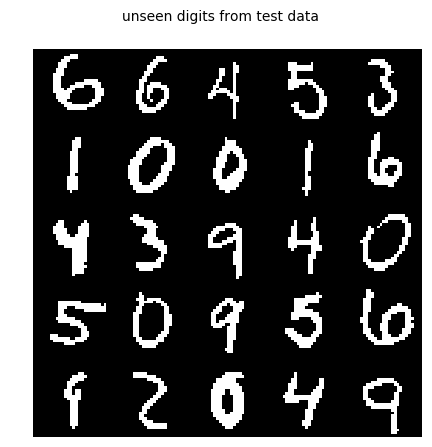

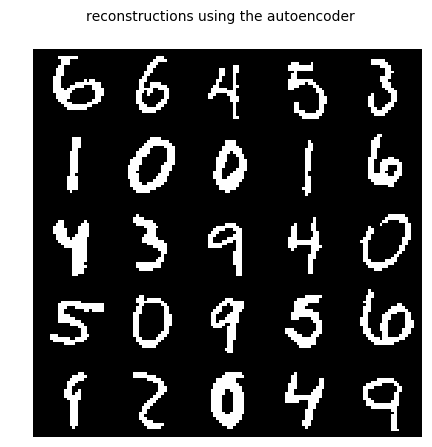

In [32]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = aes[-1].reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='unseen digits from test data')
print_image(X_rec, output_shape=(5, 5),
            title='reconstructions using the autoencoder')
None

Next, we try varying the number of hidden units for denoising autoencoders.

In [29]:
daes = []
n_hidden_units = [50, 100, 200, 500]
for i, n_hidden in enumerate(n_hidden_units):
    dae0 = Autoencoder(n_visible=784, n_hidden=n_hidden, binary=True,
                      activation='sigmoid', denoising=0.25,
                      learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                      early_stopping=True, seed=2)
    dae0.train(X_train, X_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25, 
              verbose=False)  # silent run
    daes.append(dae0)
    print('DAE #{:d} with {:d} hidden units training complete ({:d} epochs)'.format(i, n_hidden, n_epoch))
    print('Final training error: {:.5f}'.format(dae0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(dae0.validation_error[-1][1]))

DAE #0 with 50 hidden units training complete (200 epochs)
Final training error: 84.48869
Final validation error: 93.57045
DAE #1 with 100 hidden units training complete (200 epochs)
Final training error: 57.72894
Final validation error: 70.89060
======Early stopping: validation error increase at epoch 100=====
DAE #2 with 200 hidden units training complete (200 epochs)
Final training error: 39.78890
Final validation error: 53.75490
======Early stopping: validation error increase at epoch 100=====
DAE #3 with 500 hidden units training complete (200 epochs)
Final training error: 25.69300
Final validation error: 41.31058


Again, the error seems to improve by the number of hidden units. We show reconstruction results on the same set of unseen digits for the 25% DAE with 500 hidden units. The results are also quite good.

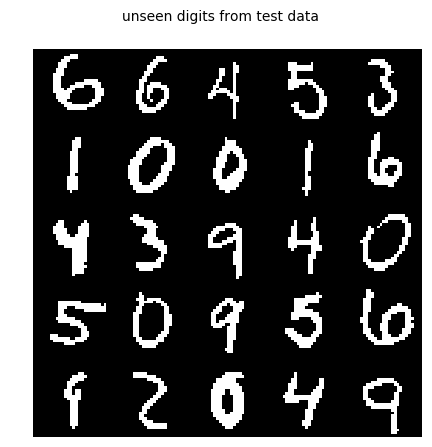

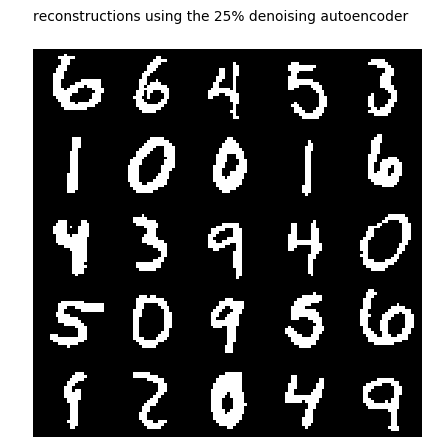

In [33]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = daes[-1].reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='unseen digits from test data')
print_image(X_rec, output_shape=(5, 5),
            title='reconstructions using the 25% denoising autoencoder')
None

We also compare the filters of the best AE and best 25%-DAE.

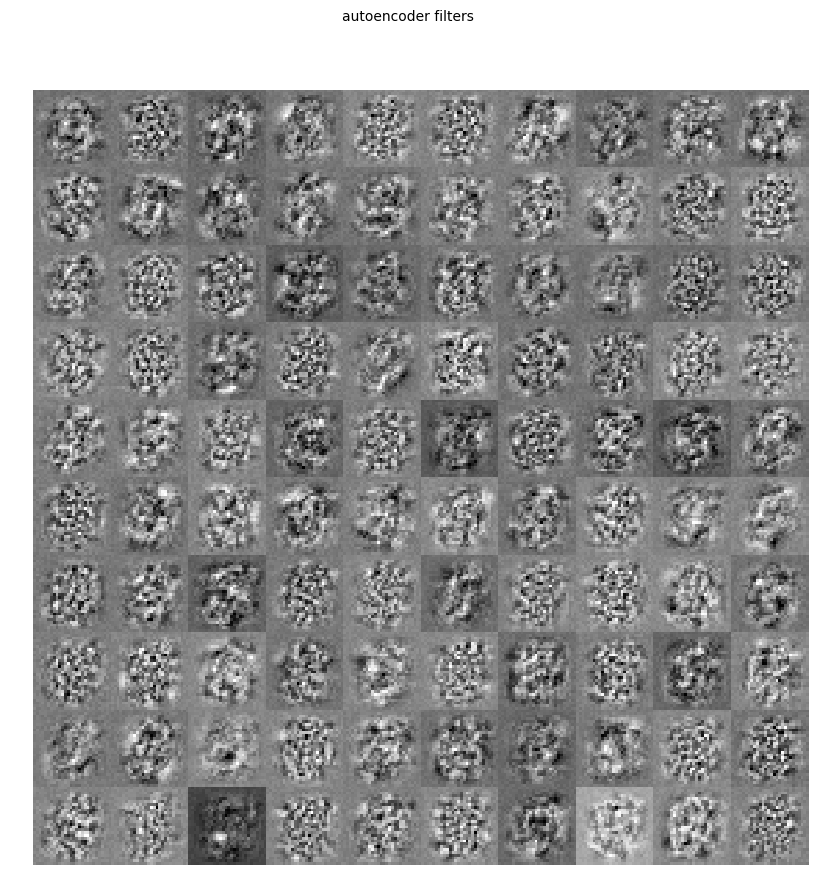

In [34]:
assert aes[-1].W.shape[0] >= 100
print_image(aes[-1].W[:100,:], output_shape=(10, 10),
            title='autoencoder filters')
None

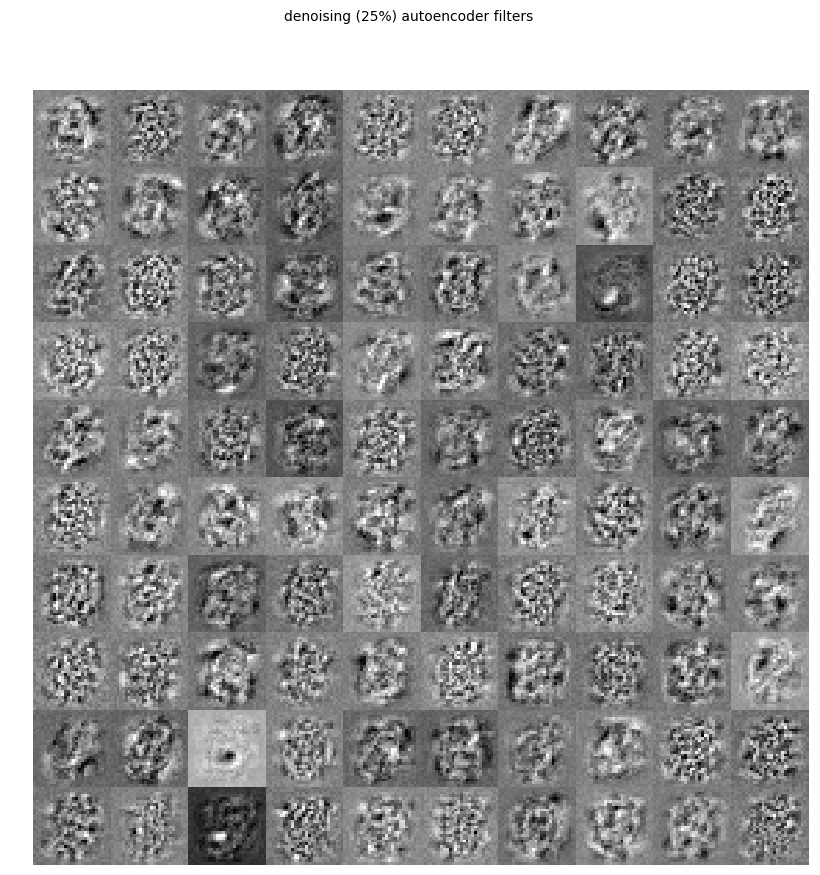

In [35]:
assert daes[-1].W.shape[0] >= 100
print_image(daes[-1].W[:100,:], output_shape=(10, 10),
            title='denoising (25%) autoencoder filters')
None

Neither filter looks like a particular shape, but we can see that it is pretty sharp in different patterns (quite a few black/white values. Compared to RBM filters, these took less epochs to find saturated filters and reconstruct unseen example quite well, although RBMs can generate new digit-like structures by seeing a similar amount of data.